# Data preprocessing for Neural Code Summarization project

Data consists of pairs (function code, function docstring). Docstring is called comment in this notebook.

Preprocessing includes comments and codes. This notebook produces the following _code_ formats:
* code as a sequence of tokens (with all punctuation removed)
* code as a seqeunce of tokens split into subtokens (with all punctuation removed)
* code as an AST (see example below)
* code as a sequence obtained from AST (see example below)

Comment preprocessing includes removing all punctuation and choosing only the first sentence.

Data filtering: remain only functions with len(code as a sequence of tokens) <= 100 & len(preprocessed comment) <= 50 & len(code as a sequence obtained from AST) <= 400.

Data is split into train/validation/test in proportion 60/20/20 percent following two strategies:
* by repository: functions from one repository owner (github user) cannot fall into both train and test;
* by function: usual data permutation and splitting.

The first way is more practically oriented, while the second way is used in the majority of papers. In addition, the results with the second split are usually more stable.

In [1]:
# run before running this notebook - this code downloads repo with data
# git clone https://github.com/EdinburghNLP/code-docstring-corpus
# cd ../code-docstring-corpus
# gunzip repo_split.data_ps.declbodies.train.gz

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
import re
from collections import defaultdict, Counter

# python tokenizer
import tokenize as py_tokenize
import token as py_token
from io import BytesIO

import torch
import numpy as np
import pandas as pd
#import en_core_web_sm

class Preprocess:    
    def __init__(self, mode):
        assert mode in ['anno', 'code']
        self.mode = mode
        
    def tokenize_python(self, snippet: str):
        toks = py_tokenize.tokenize(BytesIO(snippet.strip().encode('utf-8')).readline)
        predicate = lambda t: py_token.tok_name[t.type] not in ['ENCODING', 'NEWLINE', 'ENDMARKER', 'ERRORTOKEN']
        return [t.string for t in toks if predicate(t)]
    
    def clean(self, x):        
        x = re.sub(r'[‘…—−–]', ' ', x)
        x = re.sub(r'[?，`“”’™•°]', '', x)
        
        if self.mode == 'anno':
            x = re.sub(r'[,:;]', '', x)
            x = re.sub(r'([\+\-\*/=(){}%^&\.])', r' \1 ', x)
            x = re.sub(r'\.+$', r'', x)
        
        if self.mode == 'code':
            # x = re.sub(r'([\+\-\*/,:;=(){}%^&])', r' \1 ', x)
            x = ' '.join(self.tokenize_python(x))
        
        x = re.sub(r'[ ]+', ' ', x)
        x = x.strip()
        return x
        
    def tokenize(self, x):        
        if self.mode == 'anno':
            # TODO: something smarter?
            # return [tok.text for tok in nlp.tokenizer(x)]
            return x.split()
        
        if self.mode == 'code':
            return x.split()

In [10]:
def convert(ast):
    increase_by = {}  # count of how many idx to increase the new idx by:
    # each time there is a value node
    cur = 0
    for i, node in enumerate(ast):
        increase_by[i] = cur
        if "value" in node:
            cur += 1

    new_dp = []
    for i, node in enumerate(ast):
        inc = increase_by[i]
        if "value" in node:
            child = [i + inc + 1]
            if "children" in node:
                child += [n + increase_by[n] for n in node["children"]]
            new_dp.append({"type": node["type"], "children": child})
            new_dp.append({"value": node["value"]})
        else:
            if "children" in node:
                node["children"] = [n + increase_by[n] for n in node["children"]]
            new_dp.append(node)

    # sanity check
    children = []
    for node in new_dp:
        if "children" in node:
            children += node["children"]
    assert len(children) == len(set(children))
    return new_dp

def get_dfs(ast, only_leaf=False):
    dpt = []
    dpv = []
    for node in ast:
        dpt.append("<"+node["type"]+">")
        if "value" in node:
            dpv.append(str(node["value"]))
        else:
            dpv.append("<empty_value>")
    return dpt, dpv

### Seq and tree data, splitting by repo

In [11]:
import json
import parse_python3
import ast

In [12]:
import importlib
importlib.reload(parse_python3)

<module 'parse_python3' from '/Vol0/user/hse/nadiinchi/NeuralCodeSum/parse_python3.py'>

In [13]:
import string
def process_with_seqs_and_trees(file_code_s, file_comments_s, file_metadata_s):
    """
    reads all available data, preprocesses code as text,
    parses ASTs and converts them to Python150k format,
    and filters according to lengths and parse fails
    returns lists of 
    (code-text, code-ast, code-ast-seq, comment, repo name)
    """
    pairs = []
    for partition in ["valid", "test", "train"]:
        print("Processing", partition)
        with open(file_code_s%partition) as fin:
            data = fin.readlines()
        with open(file_comments_s%partition, errors='ignore') as fin:
            desc = fin.readlines()
        with open(file_metadata_s%partition, errors='ignore') as fin:
            repos = fin.readlines()
        repo_names = []
        for repo in repos:
            repo = repo[repo.find("/")+1:]
            repo = repo[:repo.find("/")]
            repo_names.append(repo)
        print(len(data), len(desc), len(repo_names))
        preprocess_code = Preprocess("code")
        preprocess_comment = Preprocess("anno")
        parse_fails = 0
        exclude = set(string.punctuation)
        exclude_code = set(string.punctuation)
        exclude_code.remove("_")
        for i, (code, comment, repo_name) in enumerate(\
                                zip(data, desc, repo_names)):
            try:
                piece = preprocess_comment.clean(code).replace(' DCNL DCSP ', " ").replace(' DCNL  DCSP ', " ").replace(' DCNL   DCSP ', " ").replace(' DCNL ', " ").replace(' DCSP ', " ")
                piece = ''.join(ch for ch in piece if ch not in exclude_code)
                piece1 = ' '.join(piece.split())
                piece2 = preprocess_code.clean(code).replace(" DCNL DCSP ", "\n\t").replace(" DCNL ", "\n").replace("DCSP ", "\t")
                ast_parsed = json.loads(parse_python3.parse_file(piece2, "code"))
                ast_copy = [elem.copy() for elem in ast_parsed]
                ast_seq_types, ast_seq_values = get_dfs(ast_copy)
                ast_converted = convert(ast_copy)
                comment_processed = preprocess_comment.clean(comment).replace("'", " ").replace(" DCNL", " ")
                comment_processed = comment_processed[:comment_processed.find(".")]
                comment_processed = ''.join(ch for ch in comment_processed if ch not in exclude)
                comment_processed = ' '.join(comment_processed.split()) + " ."
                if (len(piece1.split())<=100) and \
                    (len(comment_processed.split())<=50) and \
                    (len(ast_converted)<=400):
                    pairs.append([piece1, \
                                  ast_parsed, \
                                  ast_seq_types,
                                  ast_seq_values,
                                  comment_processed, \
                                  repo_name])
            except:
                parse_fails += 1
        print(parse_fails, "errors")
    return pairs

In [14]:
all_pairs = process_with_seqs_and_trees("../code-docstring-corpus/repo_split.parallel-corpus/repo_split.data_ps.declbodies.%s",\
                         "../code-docstring-corpus/repo_split.parallel-corpus/repo_split.data_ps.descriptions.%s",\
                         "../code-docstring-corpus/repo_split.parallel-corpus/repo_split.data_ps.metadata.%s"    )

Processing valid
3321 3321 3321
27 errors
Processing test
3885 3885 3885
30 errors
Processing train
143164 143164 143164
4292 errors


In [7]:
all_pairs = process_with_seqs_and_trees("../code-docstring-corpus/repo_split.parallel-corpus/repo_split.data_ps.declbodies.%s",\
                         "../code-docstring-corpus/repo_split.parallel-corpus/repo_split.data_ps.descriptions.%s",\
                         "../code-docstring-corpus/repo_split.parallel-corpus/repo_split.data_ps.metadata.%s"    )

Processing valid
3321 3321 3321
27 errors
Processing test
3885 3885 3885
30 errors
Processing train
143164 143164 143164
4292 errors


In [8]:
len(all_pairs)

124081

AST is represented as a list of nodes (depth-first traversal). Each node has type, optional value (e. g. variable name, function name, number, string etc.), and optional children (indexes of nodes in the list).

In [16]:
all_pairs[:10]

[['def client_start request socket context CLIENTSsocket session session_id request socket context',
  [{'type': 'Module', 'children': [1]},
   {'type': 'FunctionDef', 'value': 'client_start', 'children': [2, 11, 25]},
   {'type': 'arguments', 'children': [3, 10]},
   {'type': 'args', 'children': [4, 6, 8]},
   {'type': 'arg', 'children': [5]},
   {'type': 'identifier', 'value': 'request'},
   {'type': 'arg', 'children': [7]},
   {'type': 'identifier', 'value': 'socket'},
   {'type': 'arg', 'children': [9]},
   {'type': 'identifier', 'value': 'context'},
   {'type': 'defaults'},
   {'type': 'body', 'children': [12]},
   {'type': 'Assign', 'children': [13, 21]},
   {'type': 'SubscriptStore', 'children': [14, 15]},
   {'type': 'NameLoad', 'value': 'CLIENTS'},
   {'type': 'Index', 'children': [16]},
   {'type': 'AttributeLoad', 'children': [17, 20]},
   {'type': 'AttributeLoad', 'children': [18, 19]},
   {'type': 'NameLoad', 'value': 'socket'},
   {'type': 'attr', 'value': 'session'},
   

Count number of functions (objects) in each repository:

In [80]:
"""
repo_stats = {}
for _, _, _, _, repo_name in all_pairs:
    if not repo_name in repo_stats:
        repo_stats[repo_name] = 1
    else:
        repo_stats[repo_name] += 1
repo_stats.values()
"""

dict_values([183, 9, 466, 24, 8, 181, 2, 8, 1259, 224, 2, 1224, 6, 83, 2, 11, 255, 167, 2368, 2928, 1, 3, 75, 68, 3, 89, 8, 11, 156, 5, 24, 10, 1, 11, 70, 25, 217, 81, 52, 35, 154, 372, 37, 4, 38, 239, 88, 56, 6, 291, 6, 11, 8, 7, 119, 329, 1, 19, 301, 3676, 86, 20, 10, 361, 107, 7, 8, 2, 30, 1, 46, 715, 365, 25, 225, 5, 2, 1159, 621, 208, 1, 6, 23, 84, 39, 42, 9, 569, 44, 139, 56, 556, 95, 15, 79, 51, 53, 8, 29, 37, 15, 6, 6, 40, 1, 22, 44, 135, 99, 9, 6, 482, 12, 347, 174, 7, 109, 502, 5, 508, 1, 105, 35, 16, 18, 299, 1512, 33, 245, 1, 3, 4, 4, 25, 26, 375, 44, 2, 3, 5, 25, 1310, 53, 22, 69, 11, 13, 12, 22, 621, 18, 5, 2, 11, 16, 67, 90, 122, 42, 81, 52, 4, 26, 28, 125, 3, 7, 1, 156, 17, 1, 57, 440, 1, 39, 7, 9, 33, 1, 25, 32, 262, 51, 145, 182, 1958, 16, 71, 10, 7, 35, 641, 2, 24, 2, 38, 20, 10, 557, 94, 68, 672, 106, 80, 1, 11, 40, 26, 72, 33, 1, 57, 21, 4, 64, 21, 168, 24, 100, 19, 195, 34, 15, 20, 84, 6, 20, 15, 19, 71, 44, 85, 97, 2, 1, 644, 7, 1, 39, 49, 16, 62, 149, 2, 451, 48

Split by repository:

In [81]:
"""
np.random.seed(1)
repos = np.random.permutation(list(repo_stats.keys()))
alllen = len(all_pairs)
summa = 0
num = 0
while summa < 0.6*alllen:
    summa += repo_stats[repos[num]]
    num += 1
print(num, summa/alllen)
"""

519 0.6002304890235647


Train repos:

In [82]:
"""
num1 = num
sum1 = summa
train_repos = repos[:num]
repos[:num]
"""

array(['apache', 'coala', 'adobe-fonts', 'docopt', 'ansible', 'wagtail',
       'etianen', 'locustio', 'justquick', 'datastax', 'fengli', 'mzupan',
       'statsmodels', 'johnboxall', 'reddit', 'schematics', 'eliangcs',
       'OCA', 'aws', 'pupil-labs', 'graphite-project', 'CloudBotIRC',
       'viewfinderco', 'mne-tools', 'wrobstory', 'DTVD', 'eastlakeside',
       'hylang', 'airbnb', 'justdark', 'OpenTSDB', 'jtriley', 'musalbas',
       'TheRook', 'swaroopch', 'botherder', 'DanMcInerney',
       'TheAlgorithms', 'laiwei', 'pyload', 'nitishsrivastava',
       'manning23', 'mikemaccana', 'mantl', 'espressif', 'sivel',
       'mongodb-labs', 'ericflo', 'cmusatyalab', 'douban', 'buildbot',
       'pantsbuild', 'sympy', 'openstack', 'jatinshah', 'CoreSecurity',
       'geekcomputers', 'marchtea', 'jdc0589', 'plotly', 'JiYou',
       'dronekit', 'revolunet', 'luispedro', 'micheloosterhof',
       'peterhudec', 'cemoody', 'python-openxml', 'sripathikrishnan',
       'sehmaschine', 'drduh',

In [17]:
train_repos = ['apache', 'coala', 'adobe-fonts', 'docopt', 'ansible', 'wagtail',
       'etianen', 'locustio', 'justquick', 'datastax', 'fengli', 'mzupan',
       'statsmodels', 'johnboxall', 'reddit', 'schematics', 'eliangcs',
       'OCA', 'aws', 'pupil-labs', 'graphite-project', 'CloudBotIRC',
       'viewfinderco', 'mne-tools', 'wrobstory', 'DTVD', 'eastlakeside',
       'hylang', 'airbnb', 'justdark', 'OpenTSDB', 'jtriley', 'musalbas',
       'TheRook', 'swaroopch', 'botherder', 'DanMcInerney',
       'TheAlgorithms', 'laiwei', 'pyload', 'nitishsrivastava',
       'manning23', 'mikemaccana', 'mantl', 'espressif', 'sivel',
       'mongodb-labs', 'ericflo', 'cmusatyalab', 'douban', 'buildbot',
       'pantsbuild', 'sympy', 'openstack', 'jatinshah', 'CoreSecurity',
       'geekcomputers', 'marchtea', 'jdc0589', 'plotly', 'JiYou',
       'dronekit', 'revolunet', 'luispedro', 'micheloosterhof',
       'peterhudec', 'cemoody', 'python-openxml', 'sripathikrishnan',
       'sehmaschine', 'drduh', 'giampaolo', 'fzliu', 'spadgos',
       'openstack-infra', 'miracle2k', 'Rip-Rip', 'hyde', 'pennersr',
       'evennia', 'ckan', 'Fantomas42', 'gitpython-developers',
       'jumpserver', 'spesmilo', 'jmcnamara', 'ujjwalkarn',
       'chrissimpkins', 'Zulko', 'nltk', 'scikit-learn-contrib',
       'biocore', 'ajenti', 'translate', 'Exa-Networks', 'stephenmcd',
       'odoo', 'hackappcom', 'cython', 'sphinx-doc', 'sophron',
       'gelstudios', 'davidsandberg', 'SiCKRAGETV', 'chen3feng',
       'RaRe-Technologies', 'somerandomdude', 'yidao620c', 'pascanur',
       'ipython', 'SublimeCodeIntel', 'nvbn', 'protream', 'wuub',
       'SmileyChris', 'TileStache', 'rackspace', 'mininet', 'liuwons',
       'AppScale', 'QuantFans', 'pandas-dev', 'udacity', 'scrapy',
       'sopel-irc', 'gluon', 'eternnoir', 'iambus', 'pypa', 'soimort',
       '0rpc', 'hexahedria', 'kelvinxu', 'networkx', 'rembo10', 'amoffat',
       'coffeehb', 'burnash', 'gbeced', 'farcepest', 'walac',
       'coderholic', 'jschneier', 'unitedstates', 'publicsuffix', 'idank',
       'aljosa', 'samuraisam', 'ganglia', 'docker', 'mopidy',
       'python-babel', 'WeblateOrg', 'egirault', 'Yelp', 'CouchPotato',
       'sinacloud', 'yahoo', 'goldsmith', 'treeio', 'ArduPilot',
       'timothycrosley', 'qiwsir', 'moonshawdo', 'fchollet', 'defunkt',
       'mila-udem', 'Kozea', 'reviewboard', 'rapidsms', 'galaxyproject',
       'learningequality', 'pythoncn', 'karpathy', 'freenas', 'ricequant',
       'SublimeText-Markdown', 'sh4nks', 'mher', 'fxsjy', 'bup',
       'justmarkham', 'wal-e', 'jeanphix', 'zeromq', 'quantopian',
       'channelcat', 'dnouri', 'pydanny', 'sqlmapproject', 'astropy',
       'kliment', 'fogleman', 'LevPasha', 'fossasia', 'devttys0',
       'thauber', 'blei-lab', 'openframeworks', 'Miserlou', 'awesto',
       'EasyEngine', 'paicha', 'mengskysama', 'Supervisor', 'joestump',
       'cvxgrp', 'dpkp', 'carltongibson', 'aneesha', 'oppia', 'miloyip',
       'etsy', 'duckduckgo', 'elastic', 'shidenggui', 'dropbox', 'aziz',
       'dyve', 'andymccurdy', 'HelloZeroNet', 'tzutalin', 'pogodevorg',
       'MarioVilas', 'lepture', 'Jahaja', 'xchaoinfo', 'circus-tent',
       'nylas', 'sovereign', 'pcmanus', 'ytisf', 'spulec', 'googleads',
       'xhtml2pdf', 'jacobian-archive', 'beetbox', 'mnielsen', 'arskom',
       'qtile', 'Uberi', 'django-wiki', 'taigaio', 'equinusocio',
       'slackhq', 'roots', 'VikParuchuri', 'BurntSushi', 'itsmegb',
       'fabric', 'pytorch', 'gunthercox', 'ahangchen', 'midgetspy',
       'geopy', 'KeepSafe', 'daid', 'cdhigh', 'sixohsix',
       'chrisallenlane', 'praw-dev', 'crossbario', 'jelmer', 'getredash',
       'nathanborror', 'jonathanslenders', 'nipy', 'fabtools', 'boto',
       'LearnProgramming', 'openstates', 'dcos', 'chineking', 'PyCQA',
       'errbotio', 'commixproject', 'reverse-shell', 'dae', 'angr',
       'joke2k', 'gregmalcolm', 'GetBlimp', 'nvie', 'joelgrus',
       'websocket-client', 'CenterForOpenScience', 'brandon-rhodes',
       'nicolaiarocci', 'django-crispy-forms', 'yoonkim',
       'plasma-disassembler', 'lra', 'caffeinehit', 'django-nonrel',
       'digitalocean', 'overviewer', 'DataBrewery', 'Kinto', 'dlitz',
       'python-excel', 'webpy', 'MTG', 'jasperproject', 'trentm',
       'nose-devs', 'nate-parrott', 'honza', 'python-diamond', 'mongodb',
       'simon-weber', 'taobao', 'git-cola', 'web2py', 'miguelgrinberg',
       'hadynz', 'getpelican', 'amueller', 'tflearn', 'tomchristie',
       'StackStorm', 'idan', 'mobolic', 'pymc-devs', 'prakhar1989',
       'snare', 'doraemonext', 'mitsuhiko', 'n1nj4sec', 'ninja-ide',
       'asciimoo', 'vispy', 'kamalgill', 'YearOfProgramming',
       'Bitmessage', 'DataDog', 'feincms', 'bear', 'autotest',
       'apprenticeharper', 'googlemaps', 'thearn', 'euske',
       'ShangtongZhang', 'stamparm', 'chriskiehl', 'zzzeek', 'noxrepo',
       'veekun', 'facebookarchive', 'aploium', 'thumbor', 'LiuXingMing',
       'sshwsfc', 'GoogleCloudPlatform', 'python-git', 'benhamner',
       'vmware', 'CarlosGS', 'ysrc', 'edx', 'behave', 'laramies',
       'PokeAPI', 'nicolargo', 'numenta', 'certbot', 'tornadoweb',
       'ottoyiu', 'jazzband', 'gevent', 'gstarnberger', 'mailpile', 'sbp',
       'redecentralize', 'ethereum', 'mail-in-a-box', 'scrapinghub',
       'tschellenbach', 'eudicots', 'lining0806', 'volatilityfoundation',
       'seb-m', 'openshift', 'Flexget', 'pyca', 'twilio', 'ctfs',
       'david-gpu', 'pallets', 'binux', 'audreyr', 'zacharski',
       'python-telegram-bot', 'lincolnloop', 'eliben', 'bokeh',
       'zsdonghao', 'echonest', 'rhiever', 'worldveil', 'donnemartin',
       'faif', 'matthewearl', 'rolando', 'facelessuser', '9miao',
       'django', 'dask', 'home-assistant', 'flask-admin', 'Rochester-NRT',
       'getsentry', 'dpgaspar', 'openhatch', 'hzlzh', 'kivy',
       'bread-and-pepper', 'sricola', 'sahana', 'spotify', 'OfflineIMAP',
       'Theano', 'mstamy2', 'django-guardian', 'omab', 'GeoNode',
       'davidhalter', 'scipy-lectures', 'conda', 'django-mptt', 'Netflix',
       'The-Compiler', 'JasperSnoek', 'quokkaproject', 'pika', 'coto',
       'andresriancho', 'MongoEngine', 'Twentysix26', 'Tribler', 'secdev',
       'osrg', 'muricoca', 'hyperopt', 'graphific', 'mirumee', 'mrjbq7',
       'sigmavirus24', 'waditu', 'jrief', 'SublimeText', 'realpython',
       'NVIDIA', 'fritzy', 'pyinstaller', 'mwaskom', 'zulip', 'osmc',
       'smicallef', 'aparo', 'jleclanche', 'jakevdp', 'django-extensions',
       'twoscoops', 'ryankiros', 'wting', 'LiuLang', 'pfnet', 'ros',
       'digi604', 'bowenpay', 'androguard', 'django-import-export',
       'frappe', 'nodejs', 'biopython', '7sDream', 'bytefish',
       'warmheartli', 'yourlabs', 'SideBarEnhancements-org', 'adobe',
       'whtsky', 'jesolem', 'scikit-image', 'grantmcconnaughey',
       'aaronsw', 'dbcli', 'bashwork', 'sightmachine', 'tweepy',
       'cobrateam', 'divio', 'lazyprogrammer', 'Julian', 'codelucas',
       'res0nat0r', 'lebinh', 'imwilsonxu', 'goodfeli', 'DEAP',
       'django-compressor', 'mariocesar', 'django-oscar', 'mwrlabs',
       'python-zk', 'spark-mooc', 'rushter', 'nryoung',
       'MobileChromeApps', 'VitaliyRodnenko', 'powerline',
       'RunestoneInteractive', 'peterh', 'tyiannak', 'Gallopsled',
       'gorakhargosh', 'django-tastypie', 'mattupstate']

In [83]:
"""
while summa < 0.8*alllen:
    summa += repo_stats[repos[num]]
    num += 1
"""

In [84]:
"""
print(num1, (summa-sum1)/alllen)
"""

519 0.21302504754843493


Test repos:

In [85]:
"""
test_repos = repos[num1:num]
repos[num1:num]
"""

array(['charlierguo', 'facebook', 'hatRiot', 'dennybritz', 'shazow',
       'ibab', 'bitcraze', 'm0mchil', 'longld', 'USArmyResearchLab',
       'PyGithub', 'P0cL4bs', 'makerbot', 'p2pool', 'pilotmoon', 'Yinzo',
       'Runscope', 'AlessandroZ', 'pybrain', 'Katee', 'xianhu', 'benoitc',
       'out0fmemory', 'akulakov', 'Yam-cn', 'cataska', 'spyder-ide',
       'jmcarp', 'vbuterin', 'timbertson', 'shuup', 'gratipay',
       'influxdata', 'simplejson', 'kennethreitz', 'knownsec', 'numba',
       'rbgirshick', 'pinax', 'bradleyayers', 'micahflee',
       'josiahcarlson', 'lxml', 'ceph', 'coleifer', 'flask-restful',
       'maxcountryman', 'cobbler', 'martinblech', 'mkdocs', 'scipy',
       'hmmlearn', 'matplotlib', 'dib-lab', 'rtfd', 'django-nose',
       'Ultimaker', '78', 'gnemoug', 'evonove', 'falconry', 'PyMySQL',
       'xonsh', 'requests', 'pyqtgraph', 'Robot-Will', 'tensorflow',
       'bitcoin-abe', 'blaze', 'yosinski', 'gabrielfalcao', 'google',
       'utahta', 'sublimehq', 'Jon

In [18]:
test_repos = ['charlierguo', 'facebook', 'hatRiot', 'dennybritz', 'shazow',
       'ibab', 'bitcraze', 'm0mchil', 'longld', 'USArmyResearchLab',
       'PyGithub', 'P0cL4bs', 'makerbot', 'p2pool', 'pilotmoon', 'Yinzo',
       'Runscope', 'AlessandroZ', 'pybrain', 'Katee', 'xianhu', 'benoitc',
       'out0fmemory', 'akulakov', 'Yam-cn', 'cataska', 'spyder-ide',
       'jmcarp', 'vbuterin', 'timbertson', 'shuup', 'gratipay',
       'influxdata', 'simplejson', 'kennethreitz', 'knownsec', 'numba',
       'rbgirshick', 'pinax', 'bradleyayers', 'micahflee',
       'josiahcarlson', 'lxml', 'ceph', 'coleifer', 'flask-restful',
       'maxcountryman', 'cobbler', 'martinblech', 'mkdocs', 'scipy',
       'hmmlearn', 'matplotlib', 'dib-lab', 'rtfd', 'django-nose',
       'Ultimaker', '78', 'gnemoug', 'evonove', 'falconry', 'PyMySQL',
       'xonsh', 'requests', 'pyqtgraph', 'Robot-Will', 'tensorflow',
       'bitcoin-abe', 'blaze', 'yosinski', 'gabrielfalcao', 'google',
       'utahta', 'sublimehq', 'JonathanSalwan', 'hangoutsbot', 'cea-sec',
       'NervanaSystems', 'jcgregorio', 'epinna', 'sabnzbd', 'maebert',
       'ktbyers', 'CreatCodeBuild', 'getnikola', 'macropin', 'yorkoliu',
       'openai', 'wbond', 'dzone', 's3tools', 'pexpect', 'mcedit',
       'django-haystack', 'PokemonGoF', 'PokemonGoMap', 'ahmetcemturan',
       'favll', 'jdavisp3', 'Azure', 'ozgur', 'arachnys', 'Pylons',
       'blampe', 'deis', 'bottlepy', 'kbengine', 'mozilla', 'cs109',
       'SickRage', 'emilmont', 'psychopy', 'twisted', 'andialbrecht',
       'python-visualization', 'Diaoul', 'mhallsmoore', 'rg3',
       'wireservice', 'deepmind', 'robotframework', 'crsmithdev',
       'mps-youtube', 'sloria', 'IronLanguages']

Validation repos:

In [86]:
"""
valid_repos = repos[num:]
repos[num:]
"""

array(['yhat', 'shelhamer', 'python-mode', 'jupyterhub', 'qiyeboy',
       'dbader', 'littlecodersh', 'Guake', 'XiphosResearch', 'jfinkels',
       'isocpp', 'cloudera', 'MobSF', 'BrightcoveOS', 'XX-net', 'Lasagne',
       'Veil-Framework', 'naparuba', 'cloudtools', 'QuantEcon', 'ring04h',
       'jkbrzt', 'python-pillow', 'trustedsec', 'nyu-dl', 'python',
       'livid', 'platformio', 'Rapptz', 'derv82', 'Newmu', 'pytest-dev',
       'banga', 'saltstack', 'cuckoosandbox', 'RiweiChen', 'chrippa',
       'ClusterHQ', 'crowdresearch', 'minimaxir', 'ronreiter', 'laoqiu',
       'commaai', 'paramiko', 'alex', 'OpenRCE', 'explosion',
       'playframework', 'lisa-lab', 'darknessomi', 'newsapps',
       'andersbll', 'clips', 'mchristopher', 'QingdaoU', 'yenchenlin',
       'StevenBlack', 'seatgeek', 'ethereon', 'biolab', 'Valloric',
       'nneonneo', 'houtianze', 'ziggear', 'byt3bl33d3r', 'fail2ban',
       'michaelliao', 'freedomofpress', 'spragunr', 'SirVer',
       'Crypto-Expert', 'pyse

In [19]:
valid_repos = ['yhat', 'shelhamer', 'python-mode', 'jupyterhub', 'qiyeboy',
       'dbader', 'littlecodersh', 'Guake', 'XiphosResearch', 'jfinkels',
       'isocpp', 'cloudera', 'MobSF', 'BrightcoveOS', 'XX-net', 'Lasagne',
       'Veil-Framework', 'naparuba', 'cloudtools', 'QuantEcon', 'ring04h',
       'jkbrzt', 'python-pillow', 'trustedsec', 'nyu-dl', 'python',
       'livid', 'platformio', 'Rapptz', 'derv82', 'Newmu', 'pytest-dev',
       'banga', 'saltstack', 'cuckoosandbox', 'RiweiChen', 'chrippa',
       'ClusterHQ', 'crowdresearch', 'minimaxir', 'ronreiter', 'laoqiu',
       'commaai', 'paramiko', 'alex', 'OpenRCE', 'explosion',
       'playframework', 'lisa-lab', 'darknessomi', 'newsapps',
       'andersbll', 'clips', 'mchristopher', 'QingdaoU', 'yenchenlin',
       'StevenBlack', 'seatgeek', 'ethereon', 'biolab', 'Valloric',
       'nneonneo', 'houtianze', 'ziggear', 'byt3bl33d3r', 'fail2ban',
       'michaelliao', 'freedomofpress', 'spragunr', 'SirVer',
       'Crypto-Expert', 'pyserial', 'kovidgoyal', 'justinmeister',
       'viper-framework', 'jupyter', 'mbr', 'celery', 'scikit-learn',
       'spinnaker']

Split data into train/test/validation:

In [20]:
keys = ["valid", "test", "train"]
pairs_for_partitions = {key:[] for key in keys}
for pair in all_pairs:
    if pair[5] in train_repos:
        pairs_for_partitions["train"].append(pair[:5])
    elif pair[5] in test_repos:
        pairs_for_partitions["test"].append(pair[:5])
    else:
        pairs_for_partitions["valid"].append(pair[:5])

Save data:

In [14]:
!mkdir my_data
!mkdir my_data/seq_reposplit
!mkdir my_data/seq_reposplit/python

In [17]:
file_out_code_s = "my_data/seq_reposplit/python/code_nopunct_%s.txt"
file_out_ast_s = "my_data/seq_reposplit/python/ast_%s.txt"
file_out_traverse_s = "my_data/seq_reposplit/python/traverse_%s.txt"
file_out_comments_s = "my_data/seq_reposplit/python/comments_%s.txt"
for key in pairs_for_partitions:
    pairs = pairs_for_partitions[key]
    print(key, len(pairs_for_partitions[key]))
    with open(file_out_code_s%key, "w") as fout:
        fout.write("\n".join([p_[0] for p_ in pairs]))
    with open(file_out_comments_s%key, "w") as fout:
        fout.write("\n".join([p_[4] for p_ in pairs]))
    with open(file_out_ast_s%key, "w") as fout:
        fout.write("\n".join([json.dumps(p_[1]) for p_ in pairs]))
    with open(file_out_traverse_s%key, "w") as fout:
        fout.write("\n".join([" ".join(p_[2]) for p_ in pairs]))

valid 23171
test 26433
train 74477


In [22]:
file_out_traverse_types_s = "my_data/seq_reposplit/python/traverse_types_%s.txt"
file_out_traverse_values_s = "my_data/seq_reposplit/python/traverse_values_%s.txt"
for key in pairs_for_partitions:
    pairs = pairs_for_partitions[key]
    with open(file_out_traverse_types_s%key, "w") as fout:
        fout.write("\n".join([" ".join(p_[2]) for p_ in pairs]))
    with open(file_out_traverse_values_s%key, "w") as fout:
        fout.write("\n".join([" ".join(p_[3]) for p_ in pairs]))

In [23]:
!wc -l my_data/seq_reposplit/python/comments_train.txt

74476 my_data/seq_reposplit/python/comments_train.txt


In [25]:
!wc -l my_data/seq_reposplit/python/traverse_types_train.txt

74476 my_data/seq_reposplit/python/traverse_types_train.txt


In [26]:
!wc -l my_data/seq_reposplit/python/traverse_values_train.txt

74476 my_data/seq_reposplit/python/traverse_values_train.txt


In [19]:
pairs_for_partitions["train"][:10]

[['def client_start request socket context CLIENTSsocket session session_id request socket context',
  [{'type': 'Module', 'children': [1]},
   {'type': 'FunctionDef', 'value': 'client_start', 'children': [2, 11, 25]},
   {'type': 'arguments', 'children': [3, 10]},
   {'type': 'args', 'children': [4, 6, 8]},
   {'type': 'arg', 'children': [5]},
   {'type': 'identifier', 'value': 'request'},
   {'type': 'arg', 'children': [7]},
   {'type': 'identifier', 'value': 'socket'},
   {'type': 'arg', 'children': [9]},
   {'type': 'identifier', 'value': 'context'},
   {'type': 'defaults'},
   {'type': 'body', 'children': [12]},
   {'type': 'Assign', 'children': [13, 21]},
   {'type': 'SubscriptStore', 'children': [14, 15]},
   {'type': 'NameLoad', 'value': 'CLIENTS'},
   {'type': 'Index', 'children': [16]},
   {'type': 'AttributeLoad', 'children': [17, 20]},
   {'type': 'AttributeLoad', 'children': [18, 19]},
   {'type': 'NameLoad', 'value': 'socket'},
   {'type': 'attr', 'value': 'session'},
   

In [21]:
# select random (code, comment) pair
i = np.random.randint(len(all_pairs))
print(i)
print(all_pairs[i][0])
print("_"*71)
print(all_pairs[i][3])

41163
def displayFile filename print File filename is being displayed fileText archive getFileText filename gcodec writeFileMessageSuffix filename displayText fileText The gcode log file is saved as _log
_______________________________________________________________________
Parse a gcode file and display the commands .


Data distribution:

In [22]:
lens_code = np.array([len(pair[0].split()) for pair in all_pairs])
lens_comment = np.array([len(pair[3].split()) for pair in all_pairs])

Text(0.5, 0, 'comment length')

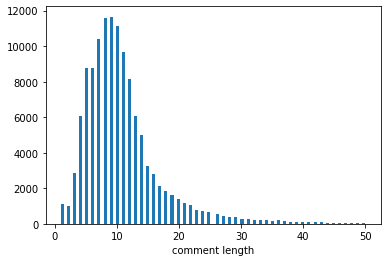

In [23]:
_ = plt.hist(lens_comment, 100)
plt.xlabel("comment length")

Text(0.5, 0, 'code length (preprocessed)')

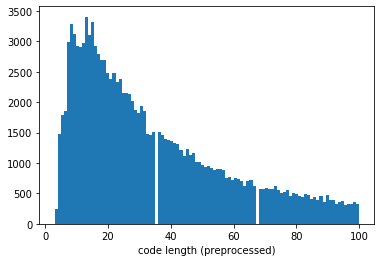

In [24]:
_ = plt.hist(lens_code, 100)
plt.xlabel("code length (preprocessed)")

In [25]:
print(np.median(lens_comment-1), np.mean(lens_comment-1)) # -1 for dot
print(np.median(lens_code), np.mean(lens_code))

8.0 9.71920761438093
27.0 33.910244114731505


Load data used in ACL20 paper and compare histograms:

In [26]:
javadoc_original = []
for key in ["train", "dev", "test"]:
    with open("data/python/%s/javadoc.original"%key) as fin:
        javadoc_original += fin.readlines()

In [27]:
code_original = []
for key in ["train", "dev", "test"]:
    with open("data/python/%s/code.original"%key) as fin:
        code_original += fin.readlines()

In [28]:
lens_original = np.array([len(comment.split()) for comment in javadoc_original])
lens_code = np.array([len(code.split()) for code in code_original])

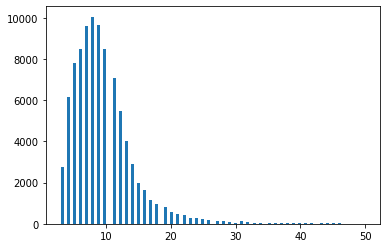

In [29]:
_ = plt.hist(lens_original, 100)

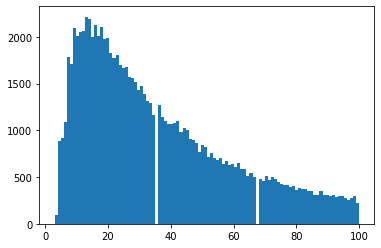

In [30]:
_ = plt.hist(lens_code, 100)

In [31]:
print(np.median(lens_original-1), np.mean(lens_original-1)) # -1 for dot
print(np.median(lens_code), np.mean(lens_code))

8.0 8.483235182884002
29.0 35.688735209897885


In [34]:
i = np.random.randint(len(javadoc_original))
print(i)
print(code_original[i])
print("_"*71)
print(javadoc_original[i])

74883
def ssh_file filename return os path join data_dir u'ssh' filename

_______________________________________________________________________
generates full path to ssh configuration file .



Save data with splitting tokens into subtokens (code is treated as text):

In [27]:
def tokenize_with_camel_case(token):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', token)
    return [m.group(0) for m in matches]

In [36]:
file_out_code_s = "my_data/seq_reposplit/python/code_nopunct_subtoken_%s.txt"
for key in pairs_for_partitions:
    pairs = pairs_for_partitions[key]
    new_seqs = []
    for pair in pairs:
        code = []
        for token in pair[0].split():
            if not "'" in token:
                for t in token.split("_"):
                    code += tokenize_with_camel_case(t)
        new_seqs.append(" ".join(code))
    print(key, len(new_seqs))
    with open(file_out_code_s%key, "w") as fout:
        fout.write("\n".join(new_seqs))

valid 23171
test 26433
train 74477


In [39]:
file_out_code_s = "my_data/seq_reposplit/python/traverse_values_%s.txt"
for key in pairs_for_partitions:
    pairs = pairs_for_partitions[key]
    new_seqs = []
    for pair in pairs:
        code = []
        for token in pair[3]:
            token = "_".join(tokenize_with_camel_case(\
                            token.strip("_").replace("___", "")\
                                            .replace("__", "")))
            code.append(token.lower())
        new_seqs.append(" ".join(code))
    print(key, len(new_seqs))
    with open(file_out_code_s%key, "w") as fout:
        fout.write("\n".join(new_seqs))

valid 23171
test 26433
train 74477


In [48]:
# max token len
for key in pairs_for_partitions:
    max_token_len = 0
    pairs = pairs_for_partitions[key]
    new_seqs = []
    for pair in pairs:
        code = []
        for token in pair[3]:
            token = "_".join(tokenize_with_camel_case(\
                            token.strip("_").replace("___", "")\
                                            .replace("__", "")))
            if len(token.split("_")) > max_token_len:
                max_token_len = len(token.split("_"))
    print(key, max_token_len)

valid 10
test 15
train 16


In [37]:
new_seqs[:10]

['def client start request socket context CLIENT Ssocket session session id request socket context',
 'def client end request socket context for channel in socket channels events on unsubscribe send request socket context channel events on finish send request socket context for channel in socket channels socket unsubscribe channel del CLIENT Ssocket session session id',
 'def client end all for request socket context in CLIENTS values client end request socket context',
 'def send session id message try socket CLIENT Ssession id1 except Key Error raise No Socket There is no socket with the session ID session id socket send message',
 'def broadcast message try socket CLIENTS values 01 except Index Error raise No Socket There are no clients socket send and broadcast message',
 'def broadcast channel message channel try socket CLIENTSCHANNELS get channel 01 except Index Error Key Error raise No Socket There are no clients on the channel channel socket send and broadcast channel message c

In [40]:
!tail my_data/seq_reposplit/python/traverse_values_test.txt

<empty_value> to_binary_string_py3 <empty_value> <empty_value> <empty_value> text <empty_value> <empty_value> <empty_value> <empty_value> isinstance text <empty_value> six binary_type <empty_value> <empty_value> text <empty_value> <empty_value> <empty_value> isinstance text <empty_value> six string_types <empty_value> <empty_value> <empty_value> <empty_value> six b text <empty_value> <empty_value> <empty_value> exception string <empty_value>
<empty_value> dbg_print_vars <empty_value> <empty_value> <empty_value> <empty_value> args <empty_value> <empty_value> inspect <empty_value> parent_locals <empty_value> <empty_value> <empty_value> <empty_value> inspect currentframe f_back f_locals <empty_value> maps <empty_value> <empty_value> arg args <empty_value> <empty_value> <empty_value> name value <empty_value> <empty_value> parent_locals items <empty_value> <empty_value> <empty_value> <empty_value> id arg <empty_value> id value <empty_value> <empty_value> <empty_value> <empty_value> maps app

In [30]:
!tail my_data/seq_reposplit/python/traverse_values_test.txt

<empty_value> _to_binary_string_py3 <empty_value> <empty_value> <empty_value> text <empty_value> <empty_value> <empty_value> <empty_value> isinstance text <empty_value> six binary_type <empty_value> <empty_value> text <empty_value> <empty_value> <empty_value> isinstance text <empty_value> six string_types <empty_value> <empty_value> <empty_value> <empty_value> six b text <empty_value> <empty_value> <empty_value> Exception string <empty_value>
<empty_value> dbg_print_vars <empty_value> <empty_value> <empty_value> <empty_value> args <empty_value> <empty_value> inspect <empty_value> parent_locals <empty_value> <empty_value> <empty_value> <empty_value> inspect currentframe f_back f_locals <empty_value> maps <empty_value> <empty_value> arg args <empty_value> <empty_value> <empty_value> name value <empty_value> <empty_value> parent_locals items <empty_value> <empty_value> <empty_value> <empty_value> id arg <empty_value> id value <empty_value> <empty_value> <empty_value> <empty_value> maps ap

In [41]:
!head my_data/seq_reposplit/python/comments_test.txt

Use refstring formatting and funcbinascii .
Populates a protobuf model from a dictionary .
Returns a dictionary containing values associated to their property names .
Normalizes the input array so that it sums to 1 .
Normalizes the input array so that the exponent of the sum is 1 .
Computes the log of input probabilities masking divide by zero in log .
Register handler to RAW if msgtype not given .
type bot smartqqbot .
type bot smartqqbot .
Checks for a cross above conditions over the specified period between two DataSeries objects .


In [40]:
!head my_data/seq_reposplit/python/ast_train.txt

[{"type": "Module", "children": [1]}, {"type": "FunctionDef", "value": "client_start", "children": [2, 11, 25]}, {"type": "arguments", "children": [3, 10]}, {"type": "args", "children": [4, 6, 8]}, {"type": "arg", "children": [5]}, {"type": "identifier", "value": "request"}, {"type": "arg", "children": [7]}, {"type": "identifier", "value": "socket"}, {"type": "arg", "children": [9]}, {"type": "identifier", "value": "context"}, {"type": "defaults"}, {"type": "body", "children": [12]}, {"type": "Assign", "children": [13, 21]}, {"type": "SubscriptStore", "children": [14, 15]}, {"type": "NameLoad", "value": "CLIENTS"}, {"type": "Index", "children": [16]}, {"type": "AttributeLoad", "children": [17, 20]}, {"type": "AttributeLoad", "children": [18, 19]}, {"type": "NameLoad", "value": "socket"}, {"type": "attr", "value": "session"}, {"type": "attr", "value": "session_id"}, {"type": "TupleLoad", "children": [22, 23, 24]}, {"type": "NameLoad", "value": "request"}, {"type": "NameLoad", "value": "

In [41]:
!head my_data/seq_reposplit/python/traverse_train.txt

<Module> <FunctionDef> client_start <arguments> <args> <arg> <identifier> request <arg> <identifier> socket <arg> <identifier> context <defaults> <body> <Assign> <SubscriptStore> <NameLoad> CLIENTS <Index> <AttributeLoad> <AttributeLoad> <NameLoad> socket <attr> session <attr> session_id <TupleLoad> <NameLoad> request <NameLoad> socket <NameLoad> context <decorator_list>
<Module> <FunctionDef> client_end <arguments> <args> <arg> <identifier> request <arg> <identifier> socket <arg> <identifier> context <defaults> <body> <For> <NameStore> channel <AttributeLoad> <NameLoad> socket <attr> channels <body> <Expr> <Call> <AttributeLoad> <AttributeLoad> <NameLoad> events <attr> on_unsubscribe <attr> send <NameLoad> request <NameLoad> socket <NameLoad> context <NameLoad> channel <Expr> <Call> <AttributeLoad> <AttributeLoad> <NameLoad> events <attr> on_finish <attr> send <NameLoad> request <NameLoad> socket <NameLoad> context <For> <NameStore> channel <SubscriptLoad> <AttributeLoad> <NameLoad> s

### Splitting data by function

Save data with train/val/test splits by _function,_ not by _repo,_ saving code as text, with and without splitting tokens into subtokens:

In [42]:
np.random.seed(1)
idxs = np.random.permutation(np.arange(len(all_pairs)))
all_pairs_permuted = [all_pairs[idx] for idx in idxs]
pairs_for_partitions_byfun = {"train":all_pairs_permuted[:int(0.6*len(all_pairs))],\
                       "valid":all_pairs_permuted[int(0.6*len(all_pairs)):int(0.8*len(all_pairs))],\
                       "test":all_pairs_permuted[int(0.8*len(all_pairs)):]}
for key in pairs_for_partitions_byfun:
    print(key, len(pairs_for_partitions_byfun[key]))

train 74448
valid 24816
test 24817


In [43]:
len(all_pairs_permuted)

124081

In [44]:
!mkdir my_data/seq_funsplit
!mkdir my_data/seq_funsplit/python

mkdir: cannot create directory ‘my_data/seq_funsplit’: File exists
mkdir: cannot create directory ‘my_data/seq_funsplit/python’: File exists


In [45]:
file_out_code_s = "my_data/seq_funsplit/python/code_nopunct_%s.txt"
file_out_ast_s = "my_data/seq_funsplit/python/ast_%s.txt"
file_out_traverse_s = "my_data/seq_funsplit/python/traverse_%s.txt"
file_out_comments_s = "my_data/seq_funsplit/python/comments_%s.txt"
for key in pairs_for_partitions_byfun:
    pairs = pairs_for_partitions_byfun[key]
    print(key, len(pairs_for_partitions_byfun[key]))
    with open(file_out_code_s%key, "w") as fout:
        fout.write("\n".join([p_[0] for p_ in pairs]))
    with open(file_out_comments_s%key, "w") as fout:
        fout.write("\n".join([p_[3] for p_ in pairs]))
    with open(file_out_ast_s%key, "w") as fout:
        fout.write("\n".join([json.dumps(p_[1]) for p_ in pairs]))
    with open(file_out_traverse_s%key, "w") as fout:
        fout.write("\n".join([" ".join(p_[2]) for p_ in pairs]))

train 74448
valid 24816
test 24817


In [43]:
file_out_traverse_types_s = "my_data/seq_funsplit/python/traverse_types_%s.txt"
file_out_traverse_values_s = "my_data/seq_funsplit/python/traverse_values_%s.txt"
for key in pairs_for_partitions_byfun:
    pairs = pairs_for_partitions_byfun[key]
    with open(file_out_traverse_types_s%key, "w") as fout:
        fout.write("\n".join([" ".join(p_[2]) for p_ in pairs]))
    with open(file_out_traverse_values_s%key, "w") as fout:
        fout.write("\n".join([" ".join(p_[3]) for p_ in pairs]))

In [47]:
file_out_code_s = "my_data/seq_funsplit/python/code_nopunct_subtoken_%s.txt"
for key in pairs_for_partitions_byfun:
    pairs = pairs_for_partitions_byfun[key]
    new_seqs = []
    for pair in pairs:
        code = []
        for token in pair[0].split():
            if not "'" in token:
                for t in token.split("_"):
                    code += tokenize_with_camel_case(t)
        new_seqs.append(" ".join(code))
    print(key, len(new_seqs))
    with open(file_out_code_s%key, "w") as fout:
        fout.write("\n".join(new_seqs))

train 74448
valid 24816
test 24817


In [44]:
file_out_code_s = "my_data/seq_funsplit/python/traverse_values_%s.txt"
for key in pairs_for_partitions_byfun:
    pairs = pairs_for_partitions_byfun[key]
    new_seqs = []
    for pair in pairs:
        code = []
        for token in pair[3]:
            token = "_".join(tokenize_with_camel_case(\
                            token.strip("_").replace("___", "")\
                                            .replace("__", "")))
            code.append(token.lower())
        new_seqs.append(" ".join(code))
    print(key, len(new_seqs))
    with open(file_out_code_s%key, "w") as fout:
        fout.write("\n".join(new_seqs))

train 74448
valid 24816
test 24817


In [48]:
!ls my_data/seq_funsplit/python

ast_test.txt			 code_nopunct_valid.txt
ast_train.txt			 comments_test.txt
ast_valid.txt			 comments_train.txt
code_nopunct_subtoken_test.txt	 comments_valid.txt
code_nopunct_subtoken_train.txt  traverse_test.txt
code_nopunct_subtoken_valid.txt  traverse_train.txt
code_nopunct_test.txt		 traverse_valid.txt
code_nopunct_train.txt


In [49]:
!head my_data/seq_funsplit/python/code_nopunct_subtoken_train.txt

def update credit request status request uuid provider id status if status not in Credit Request REQUEST STATUS APPROVED Credit Request REQUEST STATUS REJECTED raise Invalid Credit Status try request Credit Request objects get uuid request uuid provider provider id provider id old status request status request status status request save log info u Updated request with UUID s from status s to s for provider with ID s request uuid old status status provider id except Credit Request Does Not Exist msg u Credit provider with ID provider id attempted to update request with UUID request uuid but no request with this UUID is associated with the provider format provider id provider id request uuid request uuid log warning msg raise Credit Request Not Found msg
def asksaveasfilename options return Save As options show
def splitline text index text find n 1 if index return textindex textindex else return text
def extract future flags globs flags 0 for fname in future all feature names feature gl

In [50]:
!head my_data/seq_funsplit/python/comments_train.txt

Update the status of a credit request .
Ask for a filename to save as .
Splits the given text at newline .
Return the compiler flags associated with the future features that have been imported into the given namespace globs .
Get encoding that should be used for printing strings .
Returns the ISO country code equivalent of the current registered operator s MCC Mobile Country Code .
Add the x intersections for a loop into a table .
The error code is returned in the last argument by reference .
Convert a list of the following form years weeks days hours minutes To an uptime in seconds .
Copy source location lineno and coloffset attributes from oldnode to newnode if possible and return newnode .


In [51]:
!head -n 50 data/python/train/javadoc.original

pulls all flashed messages from the session and returns them .
install qt translator to the qapplication instance .
delete dhcp options by id or name .
import module by name .
w/o old-style .
given a datasource .
return the subset of the list names that match pat .
test for #148 .
test interpolation option .
helper function to save and remove a module from sys .
return a list of minions .
run migrations in offline mode .
works like turning URL => 180 .
wait until a instance is running .
convert a dictionary of dictionaries to a numpy array with optional mapping .
checks if the current suggestion has already been accepted/rejected .
calculate the default directory to use for temporary files .
returns the default site .
crosscovariance for 1d parameters x .
load the plugins specified in the configuration .
returns the serializers modules .
rgb to short .
output -> html string either return the result of a function or a sparse htmlized error message and a message in the server log .
a wra

### Compute and save relative paths

This section is needed to implement tree relative attention proposed in Kim et al., "Code Prediction by Feeding Trees to Transformers"

In [45]:
def get_ud_masks(dp, max_len):
    def get_ancestors(dp):
        ancestors = {0: []}
        node2parent = {0: 0}
        levels = {0: 0}
        for i, node in enumerate(dp):
            if "children" in node:
                cur_level = levels[i]
                for child in node["children"]:
                    node2parent[child] = i
                    levels[child] = cur_level + 1
            ancestors[i] = [i] + ancestors[node2parent[i]]
        return ancestors, levels

    def get_path(i, j):
        if i == j:
            return "<self>"
        if i - j >= max_len:
            return "0"
        anc_i = set(ancestors[i])
        for node in ancestors[j][-(levels[i] + 1) :]:
            if node in anc_i:
                up_n = levels[i] - levels[node]
                down_n = levels[j] - levels[node]
                return str(up_n + 0.001 * down_n)

    ancestors, levels = get_ancestors(dp)
    path_rels = []
    for i in range(len(dp)):
        path_rels.append(" ".join([get_path(i, j) for j in range(len(dp))]))
    return path_rels

def get_dp(dp, n_ctx, child=False):
    get_mask = get_udc_masks if child else get_ud_masks
    asts = separate_dps(dp, n_ctx)
    rel_masks = separate_rel_mask(get_mask(dp, n_ctx), n_ctx)
    aug_dps = [get_dfs(ast), ext, mask]
    return aug_dps

In [117]:
import pickle

In [46]:
file_out_relm_s = "my_data/seq_reposplit/python/rel_matrix_noconvert_%s.json"
for key in pairs_for_partitions:
    pairs = pairs_for_partitions[key]
    ud_masks = []
    for pair in pairs:
        tr = [elem.copy() for elem in pair[1]]
        ud_masks.append(get_ud_masks(tr, 10000))
    print(key, len(ud_masks))
    with open(file_out_relm_s%key, "w") as fout:
        fout.write("\n".join([json.dumps(ud_mask) for ud_mask in ud_masks]))

valid 23171
test 26433
train 74477


In [54]:
ud_masks[4637]

['<self> 0.001 0.002 0.002 0.003 0.004 0.005 0.006 0.003 0.002 0.003 0.004 0.005 0.006 0.007 0.006 0.007 0.008 0.007 0.008 0.007 0.008 0.004 0.005 0.006 0.007 0.008 0.009000000000000001 0.008 0.009000000000000001 0.006 0.007 0.008 0.003 0.004 0.005 0.006 0.007 0.006 0.007 0.008 0.009000000000000001 0.008 0.009000000000000001 0.007 0.008 0.004 0.005 0.006 0.007 0.008 0.009000000000000001 0.008 0.009000000000000001 0.006 0.007 0.008 0.003 0.004 0.005 0.006 0.007 0.008 0.007 0.008 0.006 0.007 0.006 0.005 0.006 0.004 0.005 0.006 0.003 0.004 0.005 0.006 0.007 0.006 0.007 0.005 0.006 0.005 0.002',
 '1.0 <self> 0.001 0.001 0.002 0.003 0.004 0.005 0.002 0.001 0.002 0.003 0.004 0.005 0.006 0.005 0.006 0.007 0.006 0.007 0.006 0.007 0.003 0.004 0.005 0.006 0.007 0.008 0.007 0.008 0.005 0.006 0.007 0.002 0.003 0.004 0.005 0.006 0.005 0.006 0.007 0.008 0.007 0.008 0.006 0.007 0.003 0.004 0.005 0.006 0.007 0.008 0.007 0.008 0.005 0.006 0.007 0.002 0.003 0.004 0.005 0.006 0.007 0.006 0.007 0.005 0.00

In [47]:
file_out_relm_s = "my_data/seq_funsplit/python/rel_matrix_noconvert_%s.json"
for key in pairs_for_partitions_byfun:
    pairs = pairs_for_partitions_byfun[key]
    ud_masks = []
    for pair in pairs:
        tr = [elem.copy() for elem in pair[1]]
        ud_masks.append(get_ud_masks(tr, 10000))
    print(key, len(ud_masks))
    with open(file_out_relm_s%key, "w") as fout:
        fout.write("\n".join([json.dumps(ud_mask) for ud_mask in ud_masks]))

train 74448
valid 24816
test 24817
